# Homework 3 - Interactive Viz

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import folium
import re
import sys
import branca.colormap as cm

## European unemployment rates

_Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date._

   _Use this data to build a _[Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) _which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/),how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe._

On the eurostat website, we found our dataset under 'Database by themes/Population and social conditions/Labour Market(labour)/Employment and unemployment/LFS main indicators/Unemployment - LFS adjusted series/Unemployment by sex and age - annual average'. It provides the unemployment rates up to 2016 for all european countries. On the contrary of its name, both sex and all ages are mixed.

### DataFrame preparation

We begin by preparing the csv file into a DataFrame. We only keep the measurements the most recent (the ones in 2016), then we only keep as an employment metric the percentage of active population. All others columns are dropped. 

We observed that Germany was presenting undesired value in parenthesis, thus we delete it.

In [2]:
CSV_PATH = 'data/question1/une_rt_a_1_Data.csv'
europe_df = pd.read_csv(CSV_PATH) 

# Cleaning Dataset
europe_df = europe_df.loc[europe_df['TIME'] == 2016]
europe_df = europe_df.loc[europe_df['UNIT'] == 'Percentage of active population']
europe_df = europe_df.drop(['TIME','AGE', 'SEX','UNIT','Flag and Footnotes'], axis = 1)
europe_df = europe_df[6:]
europe_df = europe_df[:30]

# Clean Germany's name
europe_df['GEO'] = europe_df['GEO'].str.replace(r"\(.*\)","")

# Define the rate as a float
europe_df['Value'] = europe_df['Value'].astype(float)

europe_df_copy = europe_df

# Delete Cyprus and Malta
europe_df = europe_df[~(europe_df['GEO'] == 'Cyprus')]
europe_df = europe_df[~(europe_df['GEO'] == 'Malta')]

europe_df.head()

,GEO,Value
1073,Belgium,7.8
1076,Bulgaria,7.6
1079,Czech Republic,4.0
1082,Denmark,6.2
1085,Germany,4.1


We know have a DataFrame containing informations about all UE countries. However, the topojson file contains more countries than our DataFrame, like Israel for example. In order to produce a pertinent plot, we have to 'grey-out' all countries for which we don't have a value. To do so, we will add every new country of the topojson to our dataframe while giving a rate value of -1.

In [3]:
# Load topoJson
state_topo_path = r'topojson/europe.topojson.json'
topo_json_data = json.load(open(state_topo_path))

In [4]:
length = europe_df.shape[0]
for i in range(0,51):
    present = 0
    for index, row in europe_df.iterrows():
        if row['GEO'] == topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME']:
            present = 1
            presence_row = row
    if present == 0:
        if topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'] == 'Switzerland':
            europe_df.loc[-1] = [topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'],3.5]
        else:
            europe_df.loc[-1] = [topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'],-1]  # adding a row
        europe_df.index = europe_df.index + 1  # shifting index
        europe_df = europe_df.sort_index()
        #europe_df = europe_df.append({'GEO'}: topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'], {'Value'}: 'NaN', ignore_index=True)

europe_df = europe_df[~(europe_df['GEO'] == 'Germany')]

### Map of european unemployment rate

In [5]:
# Define the legend
legend_ = cm.StepColormap(
    ['#fcfcfc','#FAF5D0', '#FAED88', '#FCDF02', '#FABB82','#ff6600','#ff0000'],
    vmin=2, vmax=14,
    index=[3, 4, 6, 8, 10, 12],
    caption='step'
)

In [6]:
def unemployment_color(state):
    # Bug with Germany value
    if state == 'Germany':
        value = 4.1
    else:
        value = float(europe_df.loc[europe_df['GEO'] == state, 'Value'].values)
        
    if value < 0:
        return '#000000'
    elif value < 4:
        return '#FAF5D0'
    elif value < 6:
        return '#FAED88'
    elif value < 8:
        return '#FCDF02'
    elif value < 10:
        return '#FABB82'
    elif value < 12:
        return '#ff6600'  
    else:
        return '#ff0000'

    
results_map = folium.Map([54,17], tiles='cartodbpositron', zoom_start=4)
folium.TopoJson(
    data = topo_json_data,
    object_path = 'objects.europe',
    style_function=lambda feature: {
        'fillColor': unemployment_color(feature['properties']['NAME']),
        'color' : 'black',
        'weight' : 1,
        'opacity': 0.5}).add_to(results_map)

results_map.save('UnemploymentEU.html')
results_map

In [7]:
legend_

On the graph above, one can observe the unemployment rate for most european countries. For countries which are not part of the EU, nor Switzerland will appear in grey. For all the others, a Standard Deviation Classification is chosen to separate the different unemployment rates, going from white to red while passing through yellow. The standard deviation is valued at 4.5, in order to show bigger differences we will separate the colors by half the standard deviation which is around 2. The countries in light yellow present a rate lower than 4%, yellow with 6%, light orange with 8% , orange with 10% and red for anything above.

The map can be seen [here](file:///Users/neuro/Desktop/ADA/ada-2017/Homeworks/Homework03/UnemploymentEU.html), or in the github repository under the name 'UnemploymentEU.html'.

### Comparison with Switzerland

Switzerland has already been added to our DataFrame, with an unemployment value of 3.5% taken from [here](https://tradingeconomics.com/switzerland/unemployment-rate) for December 2016. To compare it with others, we use a barplot showing every country unemployment rate listed by decreasing order.

In [8]:
# Add Switzerland Value
europe_df = europe_df_copy
europe_df.loc[-1] = ['Switzerland',3.5]  # adding a row
europe_df.index = europe_df.index + 1  # shifting index
europe_df = europe_df.sort_index()
    
# Sort by descending order
result_df = europe_df.sort_values(by = ['Value'], ascending = False)

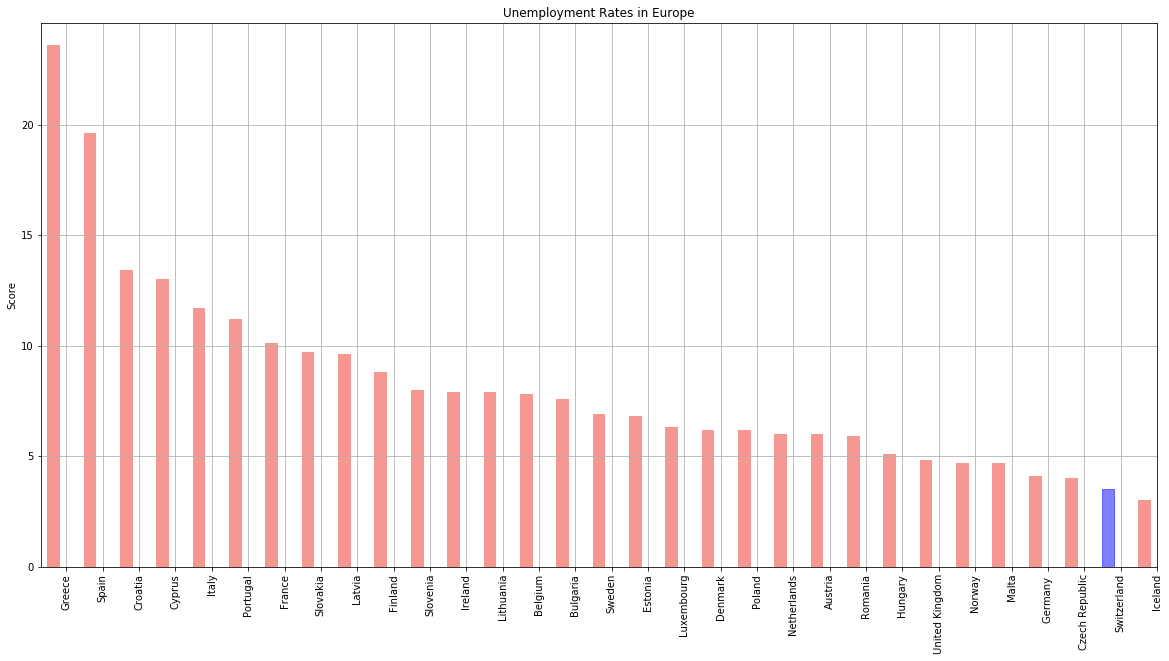

In [9]:
# Setting the positions and width for the bars
pos = list(range(len(result_df['Value']))) 
width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(20,10))

# Create a bar with pre_score data,
# in position pos,
barlist = plt.bar(pos, 
        #using df['pre_score'] data,
        result_df['Value'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=result_df['GEO']) 

# Plot Switzerland in blue
barlist[29].set_color('b')

# Set the y axis label
ax.set_ylabel('Score')

# Set the chart's title
ax.set_title('Unemployment Rates in Europe')

# Set the position of the x ticks
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(result_df['GEO'], rotation='vertical')

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width)
plt.ylim([0, max(result_df['Value'])+1] )

# Adding the legend and showing the plot
plt.grid()
plt.show()

The unemployment rate in Switzerland appears much lower than any other European country, with only Iceland showing a lower value.

## Swiss Cantons unemployement

_Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date._

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

  _ Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe._

  _ The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization._

  _ Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data._

## Foreign workers in Switzerland


_Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers._

  _The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. _

  _ Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?_

  _ Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data._

### Preparation of DataFrame

For this exercise, we need to keep track of the unemployment rate for both the locals and foreigners. We first use our dataset found on the [amstat](www.amstat.ch) website. From there, we discard all the columns in which we don't have interest. From there, we will match the cantons ID from the topojson with our dataframe using informations found on wikidata (as done in exercise 2).

In [10]:
TXT_PATH = 'data/question_2_3/swiss_unemployment.txt'
switzerland_df = pd.read_table(TXT_PATH, ',') 

# Cleaning the Dataset / Re-naming columns
switzerland_df = switzerland_df.drop('Mois', 1)
switzerland_df = switzerland_df.drop(switzerland_df.index[[0]])
switzerland_df = switzerland_df.drop(switzerland_df.index[[len(switzerland_df) - 1]])
switzerland_df = switzerland_df.rename(index=str, columns={ "Total" : "Taux de chômage", "Total.1" : "Chômeurs inscrits"});
cols = [col for col in switzerland_df.columns if col  in ['Canton', 'Nationalité', 'Taux de chômage', 'Chômeurs inscrits']]
switzerland_df = switzerland_df[cols]

switzerland_df['Chômeurs inscrits'] = switzerland_df['Chômeurs inscrits'].str.replace("'", "")

In [11]:
switzerland_df.head()

,Canton,Nationalité,Taux de chômage,Chômeurs inscrits
1,Zurich,Etrangers,5.3,120430
2,Zurich,Suisses,2.4,143239
3,Berne,Etrangers,5.7,50777
4,Berne,Suisses,1.8,83379
5,Lucerne,Etrangers,4,16379


In [12]:
previous_canton = 'None'
foreign_unempl = 0
swiss_df = pd.DataFrame(columns=['Canton','ID','Difference Foreigners-Locals'])

# Create a new DataFrame that contains the differences and the ID for each canton
# As all cantons gets two lines (one for locals and one for foreigners), we also reunite them with an if statement
for index, row in switzerland_df.iterrows():
    if row['Canton'] == previous_canton:
        swiss_df.loc[-1] = [row['Canton'],'NaN',float(foreign_unempl) - float(row['Taux de chômage'])]
        swiss_df.index = swiss_df.index + 1  # shifting index
        swiss_df = swiss_df.sort_index()
    else:
        previous_canton = row['Canton']
        foreign_unempl = row['Taux de chômage']

In [13]:
# TO_DO - Changer avec le nouveau bail de Jeannot
ID_list = ['JU','GE','NE','VS','VD','TI','TG','AG','GR','SG','AI','AR','SH','BL','BS','SO','FR','ZG','GL','NW','OW','SZ','UR','LU','BE','ZH']
swiss_df['ID'] = ID_list  
swiss_df.head()

,Canton,ID,Difference Foreigners-Locals
0,Jura,JU,5.8
1,Genève,GE,1.1
2,Neuchâtel,NE,3.8
3,Valais,VS,4.4
4,Vaud,VD,2.6


In [14]:
canton_topo_path = r'topojson/ch-cantons.topojson.json'
topo_json_data = json.load(open(canton_topo_path))

### Difference in unemployment rates between locals and foreigners in each canton

In [15]:
# Define the legend
legend__ = cm.StepColormap(
    ['#FAF5D0','#FAED88','#FCDF02','#FABB82', '#ff6600', '#b30000'],
    vmin=1, vmax=6,
    index=[1.1,2, 2.8, 3.7, 4.6, 5.5],
    caption='step'
)

In [16]:
# Color Scale
def unemployment_color(canton):

    value = float(swiss_df.loc[swiss_df['ID'] == canton, 'Difference Foreigners-Locals'].values)
        
    if value < 0:
        return '#000000'
    elif value < 2:
        return '#FAED88'#4dd400'
    elif value < 2.8:
        return '#FCDF02'#55aa00'
    elif value < 3.7:
        return '#FABB82'
    elif value < 4.6:
        return '#ff6600'  
    elif value < 5.5:
        return '#b30000'
    else:
        return '#b30000'

# TO DO - TROUVER COMMENT CHANGER L'OPACITE  
# Plot of the map
results_map = folium.Map([46.8,8.2], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(
    data = topo_json_data,
    object_path = 'objects.cantons',
    style_function=lambda feature: {
        'fillColor': unemployment_color(feature['id']),
        'opacity': 1,
        'color' : 'black',
        'weight' : 1.5,
        'opacity':0.5
        }).add_to(results_map)

results_map.save('DifferenceForeignerLocals.html')
results_map

In [17]:
legend__

The colorscale chosen in the map above depends on the Standard Deviation Classification. By observing the values of the Difference in unemployment rates, we notice that the standard deviation of the data is equal to $std = 0.9$. Therefore, we define the minimum of our colorscale at 1.1 (the minimum value) and progress with one $\sigma$ at a time.

The two Cantons where we observe the lowest value are Geneva and Obwald. Two cantons that are drastically different in their nature. Geneva lies next to the border with France, therefore a lot of 'frontaliers' (people living in France and working in Geneva) won't be counted for the unemployment rate, as the foreigners will live in France where life is less expensive. On another hand, Obwald is a central canton, located south of Lucerne. Here, the low number of foreigners might explain this low rate. 

One observation for the highest rates comes from the absence of big cities in them. For example, Jura and Valais are both next to a border, but they present a lack of attractive cities for foreigners to come and jobs to flourish.

The map can be seen [here](file:///Users/neuro/Desktop/ADA/ada-2017/Homeworks/Homework03/DifferenceForeignerLocals.html), or in the github repository under the name 'DifferenceForeignersLocals.html'.

### Difference in unemployment rates between age groups

We will now look at the differences of unemployment between age groups per cantons. In order to do that, we need a new dataset from [amstat](www.amstat.ch) containing the age category. We took the unemployment rates for September 2017, with 3 age categories: 15-24 years old, 25-49 years old and more than 50 years old.

In [18]:
TXT_PATH = 'data/question_2_3/jeune_vieux.txt'

age_df = pd.read_table(TXT_PATH, ',') 
age_df = age_df.drop(['25-49','Septembre 2017','Mesures','Coefficients de variation', 'Chômeurs inscrits','Taux de chômage.1','Total','Total_N','Total2'], axis = 1)
age_df = age_df.rename(index=str, columns={ "Classes d'âge 15-24" : "Age"});
age_df = age_df[:78]
age_df.head()

,Canton,Age,Taux de chômage
0,Zurich,1.0,3.7
1,Zurich,2.0,3.4
2,Zurich,3.0,2.9
3,Berne,1.0,2.8
4,Berne,2.0,2.5


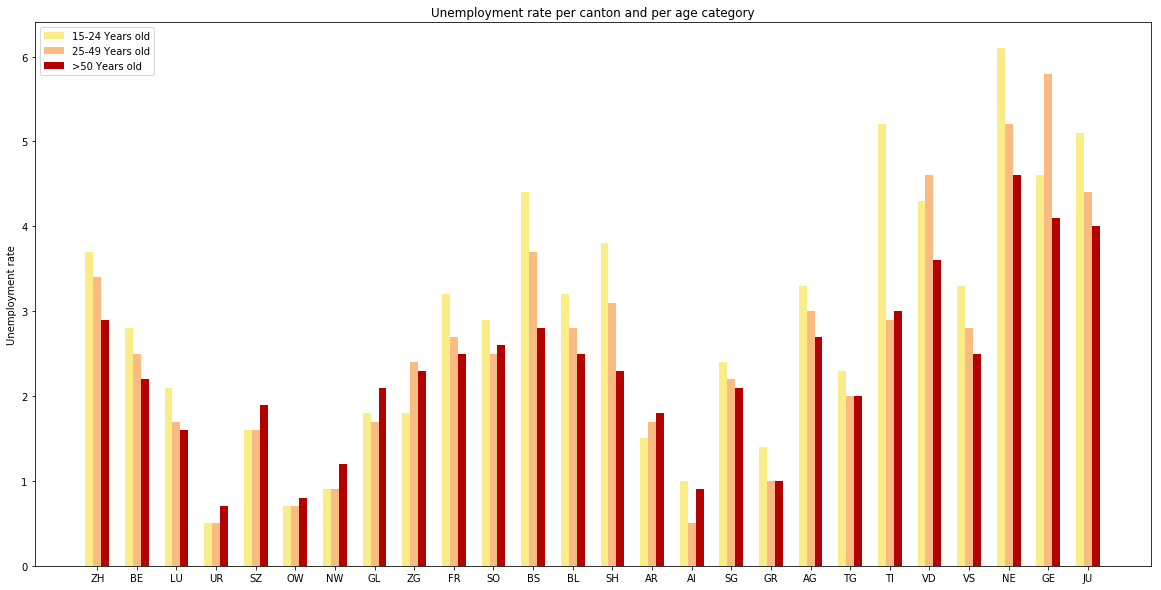

In [19]:
N = 26
young = age_df[age_df['Age']==1]
young = young['Taux de chômage'].values

ind = np.arange(N)  # the x locations for the groups
width = 0.2       # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, young, width, color='#FAED88')

middle = age_df[age_df['Age']==2]
middle = middle['Taux de chômage'].values
rects2 = ax.bar(ind + width,middle, width, color='#FABB82')

old = age_df[age_df['Age']==3]
old = old['Taux de chômage'].values
rects3 = ax.bar(ind + 2*width,old, width, color='#b30000')

ID_list = ['JU','GE','NE','VS','VD','TI','TG','AG','GR','SG','AI','AR','SH','BL','BS','SO','FR','ZG','GL','NW','OW','SZ','UR','LU','BE','ZH']

# add some text for labels, title and axes ticks
ax.set_ylabel('Unemployment rate')
ax.set_title('Unemployment rate per canton and per age category')
ax.set_xticks(ind + width)
ax.set_xticklabels(reversed(ID_list))

ax.legend((rects1[0], rects2[0],rects3[0]), ('15-24 Years old', '25-49 Years old','>50 Years old'))

plt.show()

From the plot above, we can first observe that the age category suffering the most from unemployment is the younger one (15-24 years old), even if the values stay relatively low in comparison to other european countries. In most cantons, the ones with the higher unemployment rate will be the older ones (>50 years old).

## Röstigraben

_ *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?_